In [47]:
from dataset import MyDataset,get_dataset_as_array,get_dataset_as_torch_dataset,un_normalize_image,label_names
from models import SimpleModel
import models
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sn
import pandas as pd
import matplotlib.patches as mpatches
import sklearn.metrics as met

In [48]:
#creating transformations
tr1 = transforms.RandomHorizontalFlip(p=1)
tr2 = transforms.RandomVerticalFlip(p=1)
tr3 = transforms.RandomRotation(180, resample=False, expand=False, center=None)
tr4 = transforms.ColorJitter(brightness=(0.2), contrast=0.2, saturation=0.2, hue=0.2)
tr5 = transforms.RandomGrayscale(p=1)
tr6 = transforms.GaussianBlur(1, sigma=(0.1, 2.0))
tr7 = torchvision.transforms.RandomResizedCrop((32,32), scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2)


In [49]:
data_transforms = transforms.Compose([transforms.RandomChoice([tr1,tr2,tr3,tr4,tr5,tr6,tr7])])

In [50]:
#setting batch sizes and loading the data
#####the data is loaded from the fixed datasets#####
tr_batch_size = 16
test_batch_size = 32
# the original train:'./data/train.pickle'
trainset = get_dataset_as_torch_dataset('./data/fixed_train_set.pickle')
trainset.transform = data_transforms
# the original dev:'./data/dev.pickle'
testset = get_dataset_as_torch_dataset('./data/fixed_dev_set.pickle')
num_of_examples = len(trainset)
classes = list(label_names().values())


In [51]:
# this function will compute the distrbution of labels in the data
def count_labels(dataiter,num_of_labels=None):
    
    cars = 0
    trucks = 0
    cats = 0
    try:
        while(True):
            images, labels = dataiter.next()
            cars += labels.tolist().count(0)
            trucks += labels.tolist().count(1)
            cats += labels.tolist().count(2)
    except:
        if  num_of_labels is not None:
            print(f"{cars*100/num_of_labels}% of the labels are cars")
            print(f"{trucks*100/num_of_labels}% of the labels are trucks")
            print(f"{cats*100/num_of_labels}% of the labels are cats")
        return (cars,trucks,cats)
    

In [52]:
#computing list of length len(dataset) of weights where the j's weight is the probabilty to choose the j's immage
def get_weights():
    weightsample = [0 for i in range(len(classes))]
    for i in range (len(trainset)):
        weightsample[trainset[i][1]] +=1

    weightsample = [1-(i/num_of_examples) for i in weightsample]
    weightsample[0]*=3/4
    weightsample[1]*=1.5
    weightsample[2]*=1.3
    weights = []

    for i in range (len(trainset)):
        weights.append(weightsample[trainset[i][1]])
    return weights

#print(weights)
#print(len(weights))

In [53]:
#loading the data to loaders
weights = get_weights()
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights),replacement = True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = tr_batch_size , shuffle=False, sampler=sampler)

testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False)


In [54]:
def show_all_pictures_with_labels(classes,dataiter):
    try:
        while(True):
            show_one_batch(classes,dataiter)
    except:
        print('done')

In [55]:
def show_one_batch(classes,dataiter):
    images, labels = dataiter.next() # labels should be one hot vector (or not?)
    plt.imshow(un_normalize_image(torchvision.utils.make_grid(images)))
    plt.show()
    print(' '.join('%5s' % classes[labels[j]] for j in range(tr_batch_size)))
    

33.013333333333335% of the labels are cars
32.284444444444446% of the labels are trucks
34.702222222222225% of the labels are cats


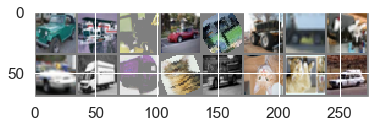

  car truck   cat   car truck truck truck   cat   car truck truck   cat truck   cat   cat   car


In [56]:
# showing one batch of data with its labels, we can see that some of the picture augmented
count_labels( iter(trainloader),num_of_examples)
show_one_batch(classes,iter(trainloader))
#show_all_pictures_with_labels(classes,iter(trainloader))

In [57]:
# train loop
#parameters: the model, train data,test data, loos function, optimizer, num of epochs
def train(model,trainloader,testloader,loss,optimizer,epochs):
    tr_losses = []
    dev_losses = []
    for ep in range(epochs):
        running_loss = 0 
        model.train()
        
        for batch_idx, data in enumerate(trainloader): 
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            tr_loss = loss(outputs, labels)
            tr_loss.backward()
            optimizer.step()
            running_loss += tr_loss.item() # sum of all batches

            if batch_idx % 1000 == 0:    # printing the loss every epoch
                    print('[%d, %5d] loss: %.3f' %
                          (ep + 1, batch_idx + 1, tr_loss.item()))      
       #evaluating on dev set
        model.eval()
        with torch.no_grad():
            running_dev_loss = 0    
            for data in testloader:
                images, labels = data
                outputs = model(images)
                dev_loss = loss(outputs, labels)
                running_dev_loss += dev_loss
            tr_losses.append(running_loss/len(trainloader))
            dev_losses.append(running_dev_loss/len(testloader))
    return tr_losses,dev_losses       

    


In [58]:
# actual train
model = SimpleModel()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00035, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
tr_losses,dev_losses = train(model,trainloader,testloader,loss,optimizer,70)

[1,     1] loss: 1.080
[2,     1] loss: 0.704
[3,     1] loss: 0.747
[4,     1] loss: 0.700
[5,     1] loss: 0.800
[6,     1] loss: 0.635
[7,     1] loss: 0.587
[8,     1] loss: 0.958
[9,     1] loss: 0.547
[10,     1] loss: 0.658
[11,     1] loss: 0.491
[12,     1] loss: 0.554
[13,     1] loss: 0.713
[14,     1] loss: 0.623
[15,     1] loss: 0.918
[16,     1] loss: 0.267
[17,     1] loss: 0.320
[18,     1] loss: 0.444
[19,     1] loss: 0.456
[20,     1] loss: 0.630
[21,     1] loss: 0.763
[22,     1] loss: 0.475
[23,     1] loss: 0.228
[24,     1] loss: 0.848
[25,     1] loss: 0.477
[26,     1] loss: 0.700
[27,     1] loss: 0.270
[28,     1] loss: 0.171
[29,     1] loss: 0.079
[30,     1] loss: 0.416
[31,     1] loss: 0.606
[32,     1] loss: 0.371
[33,     1] loss: 0.361
[34,     1] loss: 0.306
[35,     1] loss: 0.466
[36,     1] loss: 0.684
[37,     1] loss: 0.461
[38,     1] loss: 0.388
[39,     1] loss: 0.372
[40,     1] loss: 0.290
[41,     1] loss: 0.658
[42,     1] loss: 0.265
[

In [59]:

### choosing the right LR : thats the way i chose the lr (chose the one that gave the best results), more about it in the report
# model = SimpleModel()
# loss = nn.CrossEntropyLoss()
# for i in range(20):
#     r = -5 * np.random.rand()
#     alpha = 10**r
#     model = SimpleModel()
#     optimizer = torch.optim.Adam(model.parameters(), lr=alpha, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)
#     print(alpha) 
#     tr_losses,dev_losses = train(model,trainloader,testloader,loss,optimizer,30)
#     iteration = np.arange(0, len(tr_losses))
#     plt.plot(iteration, tr_losses, 'g-',iteration,dev_losses, 'r-')
#     plt.xlabel('iterations')
#     plt.ylabel('loss')
#     green_patch = mpatches.Patch(color='green', label='train')
#     red_patch = mpatches.Patch(color='red', label='dev')
#     plt.legend(handles=[green_patch,red_patch])
#     plt.show()
#     print('---------------------------------------')

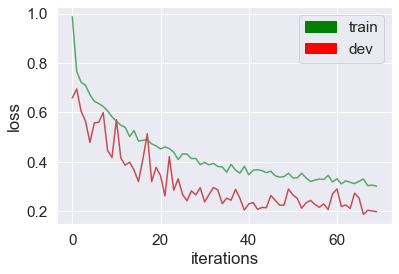

In [60]:
# plottind the losses 
# the dev bar might be below the train bar due to the diffrent distribution of the dev set
iteration = np.arange(0, len(tr_losses))
plt.plot(iteration, tr_losses, 'g-',iteration,dev_losses, 'r-')
plt.xlabel('iterations')
plt.ylabel('loss')
green_patch = mpatches.Patch(color='green', label='train')
red_patch = mpatches.Patch(color='red', label='dev')
plt.legend(handles=[green_patch,red_patch])
plt.show()

In [72]:
#saving the model
path = './313419814.ckpt'
model.save(path)

GroundTruth:    car truck   car truck   car   car   car truck   car   car   car   car   car   car   car   car   car   car   car   car   car   car   car   car   car   car   car   car   car   cat   car   car


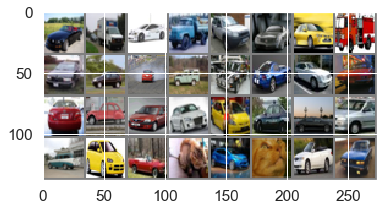

In [62]:
# testset visualization
dataiter = iter(testloader)
images, labels = dataiter.next()
plt.imshow(un_normalize_image(torchvision.utils.make_grid(images)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(test_batch_size)))

      

In [63]:
count_labels( iter(testloader),len(testset))

82.08% of the labels are cars
8.16% of the labels are trucks
9.76% of the labels are cats


(513, 51, 61)

In [64]:
# evaluates the model with f1 score and confusion matrix
def evaluate(model,loader,train_or_test):
    if train_or_test == 'train':
        batch = tr_batch_size
    else:
        batch = test_batch_size
    model.eval()
    label_list = []
    predicted_list = []
    for data in loader:
        images, labels = data
        label_list.extend(labels.tolist())
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_list.extend(predicted.tolist())
   
    ### f1_score
    f1_score = met.f1_score(label_list, predicted_list, average = 'macro')*100
    print(' f1_score of the network %s images: %d %%' % (train_or_test,
        f1_score))
    ### confusion matrix
    mat = met.confusion_matrix(label_list, predicted_list, labels =[0,1,2])
    
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    df_cm = pd.DataFrame(mat, index = [i for i in classes],
                  columns = [i for i in classes])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}) # font size
    
    plt.show()
    for i in range(len(classes)):
        print('  %s accuracy of %s images: %d %%' % (classes[i],train_or_test,
        mat[i][i]*100/(mat[i][0]+mat[i][1]+mat[i][2])))
         

 f1_score of the network train images: 89 %


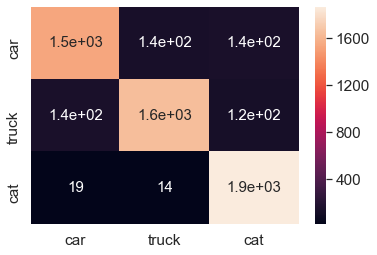

  car accuracy of train images: 84 %
  truck accuracy of train images: 86 %
  cat accuracy of train images: 98 %
------------------------------------------
 f1_score of the network test images: 84 %


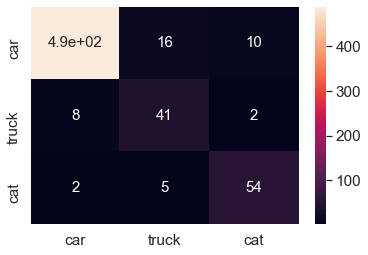

  car accuracy of test images: 94 %
  truck accuracy of test images: 80 %
  cat accuracy of test images: 88 %


In [69]:
evaluate(model,trainloader,'train')
print('------------------------------------------')
evaluate(model,testloader,'test')

C:\Users\tim89\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 f1_score of the network test images: 30 %


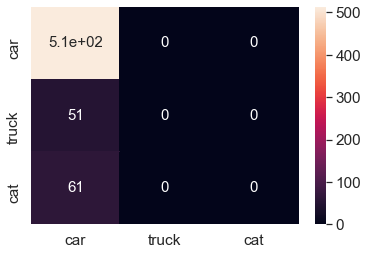

  car accuracy of test images: 100 %
  truck accuracy of test images: 0 %
  cat accuracy of test images: 0 %


In [66]:
# loading the pretrained model and evaluating it 
pre_trained_model = SimpleModel()
pre_trained_model.load('./data/pre_trained.ckpt')
evaluate(pre_trained_model,testloader,'test')

# the model is classifying everything as cars, we can see that although the overall accuracy isnt bad(88%)
# the f1 score is very low 

In [21]:
###### adverarial example

In [22]:
from __future__ import print_function
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
%matplotlib inline

In [23]:
## fetching the model
model = SimpleModel()
model.load(path)
model.eval()

SimpleModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [24]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = un_normalize_image(x) 
    #x = np.transpose( x , (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = un_normalize_image(x_adv)  
    
    #x_adv = np.transpose( x_adv , (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

In [25]:
# computing the confidence of the model
def compute_confidence(item,label):
    exp_output = torch.exp(item)
    confidence = exp_output[0][label] / (exp_output[0][0]+exp_output[0][1]+exp_output[0][2])
    print('model confidence that the image is %s: %d %%' % (classes[label],confidence*100))
    return confidence

In [26]:
epsilon = 0.25
num_steps = 5
alpha = 0.025

In [44]:
def generate_adversarial(model,dataset,num_of_pic,target,epsilon = 0.25,num_steps = 5,alpha = 0.025):
    # fetching the image and the output of the model for it
    
    image,label = dataset[num_of_pic]
    ytarget = 2
    target = Variable(torch.LongTensor([ytarget]), requires_grad=False) 
    plt.imshow(un_normalize_image(image))
    image_tensor = image.unsqueeze(0) 
    img_variable = Variable(image_tensor, requires_grad=True)
    output = model.forward(img_variable)
    
    # computing the confidence of the model for the image
    confidence = compute_confidence(output,label)
    
    # running forward the model while "training" the picture
    loss = nn.CrossEntropyLoss()
    for i in range(num_steps):
        zero_gradients(img_variable)
        output = model.forward(img_variable)
        loss_cal = loss(output, target)
        loss_cal.backward()
        x_grad = alpha * torch.sign(img_variable.grad.data)
        adv_temp = img_variable.data - x_grad
        total_grad = adv_temp - image_tensor
        total_grad = torch.clamp(total_grad, -epsilon, epsilon)
        x_adv = image_tensor + total_grad
        img_variable.data = x_adv
        
    # running the updated picture in the model and visualizing the results
    output_adv = model.forward(img_variable)
    x_adv_pred = classes[torch.max(output_adv.data, 1)[1][0]]  #classify adversarial example
    output_adv_probs = F.softmax(output_adv, dim=1)
    x_adv_pred_prob =  (torch.max(output_adv_probs.data, 1)[0][0]) * 100,4
    visualize(image_tensor, img_variable.data, total_grad, epsilon, classes[label],x_adv_pred, confidence*100,  x_adv_pred_prob[0].tolist())
    return (image_tensor, img_variable.data, total_grad, epsilon, classes[label],x_adv_pred, confidence*100,  x_adv_pred_prob[0].tolist())

In [45]:
#dataset --> the dataset to take the picture from
#num_of_pic --> the number of image in the dataset
# target--> "trick" the model into classifying the picture to target

truck
model confidence that the image is truck: 96 %


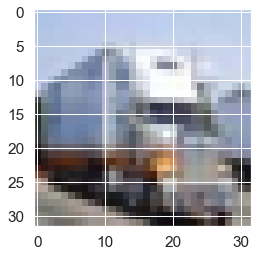

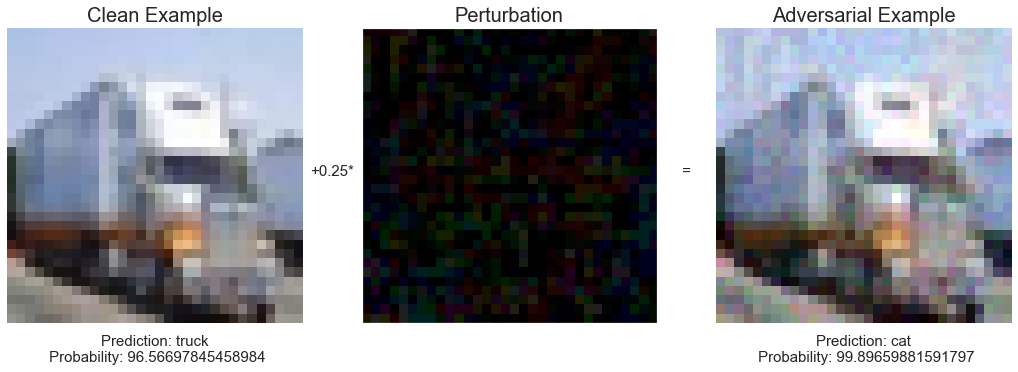

In [46]:
#actually generating the image
trainset_for_adv = get_dataset_as_torch_dataset('./data/train.pickle')
results = generate_adversarial(model,trainset_for_adv,23,2,epsilon = 0.25,num_steps = 5,alpha = 0.025)

In [30]:
########## trying to fix labels  the code writen messy because the lack of time :(
# cat_images = []
# for i in range(len(trainset)):
#     image,label = trainset_for_adv[i]
#     image_tensor = image.unsqueeze(0) 
#     img_variable1 = Variable(image_tensor)
    
#     ouptut = model.forward(img_variable1)
#     predicted = torch.max(ouptut.data, 1)[1][0]
#     if predicted == 2 and not label == 2:
#         cat_images.append(i)

In [31]:
# print(cat_images)

In [32]:

# labels = [5573, 5575, 5576, 5602, 5607, 5623]

# images=[]
# labels_wrong=[]
# for i in labels:
 
#     image,label = trainset_for_adv[i]
    
#     labels_wrong.append(label)
#     images.append(image)
    
# plt.imshow(un_normalize_image(torchvision.utils.make_grid(images)))
# print(labels_wrong)

In [33]:
# to_fix_labels = [4, 20, 35, 37, 57, 84, 86, 96, 126, 131, 153, 154, 167, 230, 234, 244, 249, 251, 256, 262, 276, 280, 286, 296,  421, 515, 533, 538, 542, 552, 560, 630, 643, 667, 681,  699, 718, 721,  764, 777, 793, 802, 810, 819, 827, 892,   928, 975, 980, 1023, 1040, 1055, 1063, 1072, 1075, 1087, 1130, 1145, 1182, 1192,  1230, 1273, 1275, 1276, 1285, 1300, 1313, 1318, 1335, 1357, 1385, 1409, 1411, 1413, 1437, 1438, 1476, 1587, 1625, 1627, 1677, 1694, 1718, 1755, 1767, 1774, 1805, 1827, 1843, 1856, 1889, 1896, 1934, 1958, 1963, 1969, 2003, 2022, 2027, 2065, 2090,  2167, 2173, 2176, 2204, 2212, 2215,  2254, 2279, 2302, 2310, 2312, 2326, 2329, 2341, 2346, 2373, 2382, 2415, 2460, 2466, 2468, 2475, 2497, 2502, 2546, 2553,  2590, 2591, 2607, 2611, 2621, 2636, 2638, 2644, 2652, 2660, 2664, 2703, 2711, 2737, 2748, 2757, 2763, 2820, 2858, 2882, 2886, 2903, 2936,  2945, 2946, 2957, 2960, 2961, 2983, 3010, 3029, 3060, 3077, 3082,  3100, 3127,  3177,  3256, 3281, 3303, 3314, 3323, 3353, 3408, 3414, 3418, 3448, 3454, 3478, 3483, 3484, 3486, 3489, 3503,  3524, 3527, 3538, 3549, 3554, 3555, 3559, 3585, 3591, 3629, 3646, 3650, 3668, 3731, 3753, 3768, 3803,  3834, 3844, 3861, 3889, 3901, 3906, 3916, 3934, 3938, 3940, 3942, 3947, 3970, 4015, 4028,  4048, 4081, 4099,  4108, 4118, 4122,  4146, 4151, 4167, 4207, 4223, 4227, 4249, 4253, 4275, 4281, 4293, 4331, 4355, 4414, 4427, 4430, 4474,  4535, 4541, 4553,  4591, 4593, 4606,  4616, 4622, 4671, 4686, 4690, 4712, 4728, 4730, 4763, 4771, 4776, 4807, 4819, 4857, 4864, 4865, 4873, 4889,  4939, 4941, 4961, 4970, 4978, 4985, 4991, 5035, 5047, 5055, 5068, 5080, 5086, 5087, 5089, 5105, 5114, 5124, 5133, 5136, 5142, 5148, 5149, 5173, 5192, 5217, 5227, 5238, 5248, 5254, 5269, 5301,  5338, 5341, 5407, 5411, 5415, 5422, 5439, 5443,  5470, 5480, 5489, 5508, 5545, 5563, 5565, 5573, 5575, 5602, 5607, 5623]

In [34]:
# testset_for_adv = get_dataset_as_torch_dataset('./data/dev.pickle')
# cat_images = []
# for i in range(len(testset)):
#     image,label = testset_for_adv[i]
#     image_tensor = image.unsqueeze(0) 
#     img_variable1 = Variable(image_tensor)
    
#     ouptut = model.forward(img_variable1)
#     predicted = torch.max(ouptut.data, 1)[1][0]
#     if predicted == 2 and not label == 2:
#         cat_images.append(i)

In [35]:
# print(cat_images)

In [36]:
# labels = [ 407, 416, 418, 420, 435, 452, 454, 482, 489, 521, 533, 536, 539, 553, 561, 566, 577, 590, 591, 624]

# images=[]
# labels_wrong=[]
# for i in labels:
 
#     image,label = testset_for_adv[i]
    
#     labels_wrong.append(label)
#     images.append(image)
    
# plt.imshow(un_normalize_image(torchvision.utils.make_grid(images)))
# print(labels_wrong)

In [37]:
# to_fix_labels2 = [35, 44, 91,  105, 130, 153, 193, 213, 250,  281, 284, 310, 312, 327, 342, 348, 355, 384, 400, 407, 418, 420, 435, 452, 454, 482, 489, 521, 533, 536, 539, 553, 561, 566, 577, 590, 591, 624]

In [38]:
# import pickle
# def get_mislabeling( train_dataset,to_fix_labels,path):
    
#     # print('\n'.join('{}' for _ in range(len(val_losses))).format(*val_losses))
#     fixed_dataset_list = []
#     for i in range(len(train_dataset)):

#         image, label = train_dataset[i]
#         if i in to_fix_labels:
#             label = 2
# #             plt.imshow(un_normalize_image(image))
# #             plt.title(f'{label_names()[label]} index: {i}')
# #             plt.show()
            
#         fixed_dataset_list.append((image, label))
    

#     with open(path, 'wb') as handle:
#         pickle.dump(fixed_dataset_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
# train_dataset = get_dataset_as_torch_dataset(path='./data/train.pickle')
# train_data = torch.utils.data.DataLoader(train_dataset, batch_size=1,
#                                  shuffle=False)
# count_labels(iter(train_data),num_of_examples)    
# path = './data/fixed_train_set.pickle'
# get_mislabeling(train_dataset,to_fix_labels,path)

# fixed_train_dataset = get_dataset_as_torch_dataset(path=path)
# fixed_train_data = torch.utils.data.DataLoader(fixed_train_dataset, batch_size=1,
#                                  shuffle=False)
# count_labels(iter(fixed_train_data),num_of_examples)

In [40]:
# dev_dataset = get_dataset_as_torch_dataset(path='./data/dev.pickle')

# dev_data = torch.utils.data.DataLoader(dev_dataset, batch_size=1,
#                                  shuffle=False)
# count_labels(iter(dev_data),len(dev_dataset))    
# path = './data/fixed_dev_set.pickle'
# get_mislabeling(dev_dataset,to_fix_labels2,path)

# fixed_dev_dataset = get_dataset_as_torch_dataset(path=path)
# fixed_dev_data = torch.utils.data.DataLoader(fixed_dev_dataset, batch_size=1,
#                                  shuffle=False)
# count_labels(iter(fixed_dev_data),len(dev_dataset))